In [11]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

In [8]:
# define LLM and dataset here
LLM_name = 'GPT'
dataset_name = 'imdb'
log_dir = "./paper_logs/GPT/imdb-GPT-small/"
# get all .log files in the directory
files = [f for f in os.listdir(log_dir) if f.endswith('.log')]
files.sort()
# divide the files into different cascade sizes
cascades = {}
for f in files:
    cascade_size = f.split('_')
    if '_'.join(cascade_size[0:-1]) not in cascades:
        cascades['_'.join(cascade_size[0:-1])] = []
    cascades['_'.join(cascade_size[0:-1])].append(f)

cascade size:  2
LR_BERT-base_0.00001.log  LLM cost:  5833.75 Overall accuracy:  0.9298
LR_BERT-base_0.00003.log  LLM cost:  6191.249999999999 Overall accuracy:  0.9279
LR_BERT-base_0.00005.log  LLM cost:  5492.5 Overall accuracy:  0.9299
LR_BERT-base_0.00007.log  LLM cost:  5113.749999999999 Overall accuracy:  0.9301
LR_BERT-base_0.00009.log  LLM cost:  4911.249999999999 Overall accuracy:  0.9244
LR_BERT-base_0.00010.log  LLM cost:  4485.0 Overall accuracy:  0.929
LR_BERT-base_0.00011.log  LLM cost:  4742.499999999999 Overall accuracy:  0.9266
LR_BERT-base_0.00013.log  LLM cost:  4423.75 Overall accuracy:  0.9285
LR_BERT-base_0.00015.log  LLM cost:  3746.250000000001 Overall accuracy:  0.9211
LR_BERT-base_0.00017.log  LLM cost:  3671.2499999999995 Overall accuracy:  0.9238
LR_BERT-base_0.00019.log  LLM cost:  3558.750000000001 Overall accuracy:  0.9248
LR_BERT-base_0.00020.log  LLM cost:  2983.7500000000005 Overall accuracy:  0.9079
LR_BERT-base_0.00030.log  LLM cost:  2585.0 Overall 

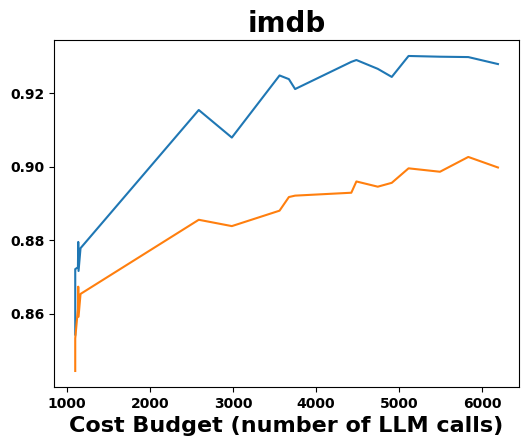

In [7]:
def plot_figure(cascade_logs, cascade_costs):
    plt.rcdefaults()
    # define figure size
    plt.figure(figsize=(6, 4.5))
    plt.rcParams["font.weight"] = "bold"
    # bold the x and y axis labels
    plt.rcParams["axes.labelweight"] = "bold"

    cascade_size = len(cascade_logs[0].split('_')) - 1
    print("cascade size: ", cascade_size)
    costs = []
    accus = []
    linear_accus = []
    # plot the data
    for f in cascade_logs:
        num_lines = sum(1 for line in open(log_dir + f))
        # read last line of the file
        with open(log_dir + f, 'r') as file:
            last_line = file.readlines()[-2]
        # data format: '''m1_prediction, m2_prediction, ..., llm_prediction, ground_truth, m1_proportion, m2_proportion, ..., m1_defer_prob, m2_defer_prob, ..., m1_score, m2_score, ..., m1_accuracy, m2_accuracy, llm_accuracy, overall_accuracy'''
        data = re.split(',', last_line.strip())
        model_prop = []
        linear_combination_acc = 0
        for k in range(cascade_size):
            model_prop.append(float(data[k + cascade_size + 2]))
            linear_combination_acc += float(data[k + cascade_size * 4 + 2]) * float(data[k + cascade_size + 2])
            
        llm_cost = 1 - sum(model_prop)
        model_accu = []
        for k in range(cascade_size):
            model_accu.append(float(data[k + cascade_size * 4 + 2]))
        llm_accuracy = float(data[k + cascade_size * 4 + 3])
        overall_accuracy = float(data[k + cascade_size * 4 + 4])
        linear_combination_acc += llm_accuracy * llm_cost

        costs.append(llm_cost * num_lines)
        accus.append(overall_accuracy)
        linear_accus.append(linear_combination_acc)
        print(f, ' LLM cost: ', llm_cost * num_lines, 'Overall accuracy: ', overall_accuracy)

    # sort the data then plot
    costs = np.array(costs)
    accus = np.array(accus)
    idx = np.argsort(costs)
    costs = costs[idx]
    accus = accus[idx]
    plt.plot(costs, accus, label = 'Online Cascade Learning')
    linear_accus = np.array(linear_accus)
    linear_accus = linear_accus[idx]
    # add LLM as a horizontal dotted line
    plt.plot(costs, linear_accus, label = 'Online Ensemble Learning')

    plt.xlabel('Cost Budget (number of LLM calls)', fontsize=16, weight='bold')

    plt.title(dataset_name, weight='bold', fontsize=20)

    # write to pdf file
    size = "small" if cascade_size == 2 else "large"
    plt.show()

cascade_name = 'LR_BERT-base'
cascade_logs = cascades[cascade_name]
cascade_costs = [1, 1182]

plot_figure(cascade_logs, cascade_costs)

2
0.0058
0.7005
LLM cost:  0.29369999999999996
LLM absolute cost:  3671.2499999999995


/tmp/ipykernel_2016135/1056109957.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])


<Figure size 600x450 with 0 Axes>

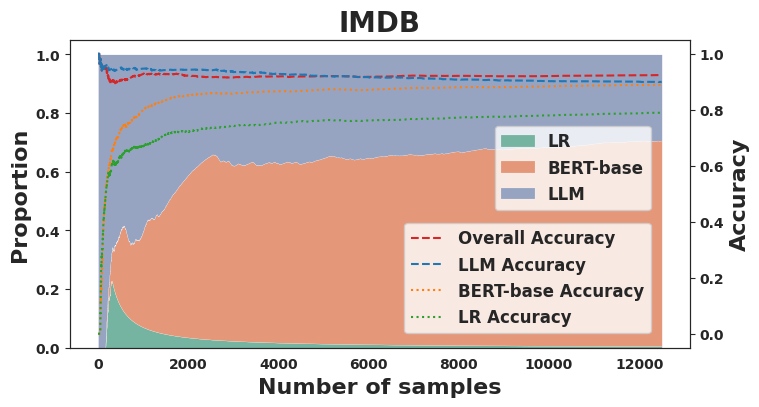

In [10]:
# define LLM and dataset here
dataset_name = 'IMDB'
log_dir = "./paper_logs/GPT/imdb-GPT-small/"

colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()
log_name = 'LR_BERT-base_0.00017.log' 
plt.figure(figsize=(6, 4.5))

cascade_size = len(log_name.split('_')) - 1
print(cascade_size)
model_prop = [[] for i in range(cascade_size)]
llm_prop = []
model_accu = [[] for i in range(cascade_size)]
model_de_facto_accu = [[] for i in range(cascade_size)]
llm_acc, overall_acc = [], []
with open(log_dir + log_name) as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        for k in range(cascade_size):
            model_prop[k].append(float(data[k + cascade_size + 2]))
        llm_prop.append(1 - sum(model_prop[i][-1] for i in range(cascade_size)))
        for k in range(cascade_size):
            model_de_facto_accu[k].append(float(data[k + cascade_size * 3 + 2]))
        for k in range(cascade_size):
            model_accu[k].append(float(data[k + cascade_size * 4 + 2]))
        llm_acc.append(float(data[k + cascade_size * 4 + 3]))
        overall_acc.append(float(data[k + cascade_size * 4 + 4]))

with open(log_dir + log_name, 'r') as file:
    last_line = file.readlines()[-2]
        
final_prop = []
data = re.split(',', last_line.strip())
for k in range(cascade_size):
    final_prop.append(float(data[k + cascade_size + 2]))
    print (data[k + cascade_size + 2])
llm_cost = 1 - sum(final_prop)
print('LLM cost: ', llm_cost)
num_lines = sum(1 for line in open(log_dir + log_name))
LLM_abosolute_cost = llm_cost * num_lines
print('LLM absolute cost: ', LLM_abosolute_cost)
# round up the LLM cost to the nearest integer
LLM_abosolute_cost = int(LLM_abosolute_cost + 0.5)
    
# plot the proportion on a stacked plot
fig, ax1 = plt.subplots()
ax1.stackplot(range(len(overall_acc)), model_prop, llm_prop, labels=log_name.split('_')[:-1] + ["LLM"], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_xlabel('Number of samples', fontsize=16, weight='bold')
ax1.set_ylabel('Proportion', fontsize=16, weight='bold')
ax1.legend(loc='lower right', framealpha=.8,  bbox_to_anchor=(0.95, 0.42), fontsize=12)

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', fontsize=16, weight='bold')

ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])
ax2.plot(llm_acc, '--', label='LLM Accuracy', color=colors2[0])

model_accu = model_accu[::-1]
for idx, label in enumerate(cascade_name.split('_')[::-1]):
    ax2.plot(model_accu[idx], ':', label=label + ' Accuracy', color=colors2[idx+1])

ax2.legend(loc='lower right', framealpha=.8, bbox_to_anchor=(0.95, 0.02), fontsize=12)

log_name = log_name.split('.')[1]
fig.set_size_inches(8, 4)
plt.title(dataset_name, weight='bold', fontsize=20)
plt.savefig(dataset_name + '_' + str(LLM_abosolute_cost) + '_' + LLM_name + '_cascade.pdf', bbox_inches='tight')
plt.show()

## fever

2
0.0000
0.1908
LLM cost:  0.8092
LLM absolute cost:  2634.7552


/tmp/ipykernel_2016135/1217776961.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])


<Figure size 600x450 with 0 Axes>

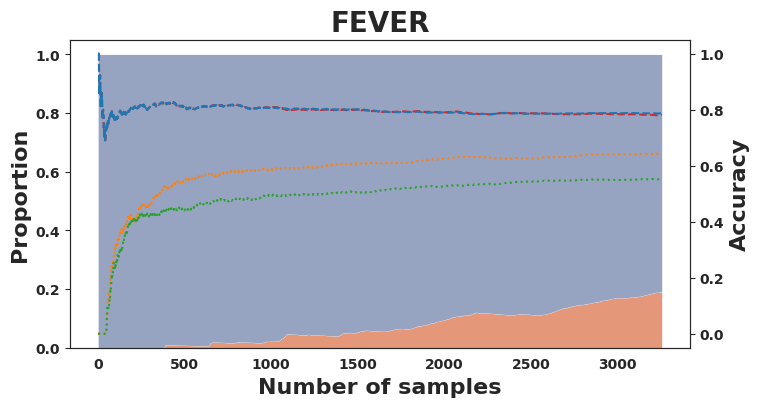

In [12]:
dataset_name = 'FEVER'
log_dir = "./paper_logs/GPT/fever-GPT-small/"

colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()
log_name = 'LR_BERT-base_0.000400.log'
plt.figure(figsize=(6, 4.5))

cascade_size = len(log_name.split('_')) - 1
print(cascade_size)
model_prop = [[] for i in range(cascade_size)]
llm_prop = []
model_accu = [[] for i in range(cascade_size)]
model_de_facto_accu = [[] for i in range(cascade_size)]
llm_acc, overall_acc = [], []
with open(log_dir + log_name) as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        for k in range(cascade_size):
            model_prop[k].append(float(data[k + cascade_size + 2]))
        llm_prop.append(1 - sum(model_prop[i][-1] for i in range(cascade_size)))
        for k in range(cascade_size):
            model_de_facto_accu[k].append(float(data[k + cascade_size * 3 + 2]))
        for k in range(cascade_size):
            model_accu[k].append(float(data[k + cascade_size * 4 + 2]))
        llm_acc.append(float(data[k + cascade_size * 4 + 3]))
        overall_acc.append(float(data[k + cascade_size * 4 + 4]))

with open(log_dir + log_name) as file:
    last_line = file.readlines()[-2]

final_prop = []
data = re.split(',', last_line.strip())
for k in range(cascade_size):
    final_prop.append(float(data[k + cascade_size + 2]))
    print (data[k + cascade_size + 2])
llm_cost = 1 - sum(final_prop)
print('LLM cost: ', llm_cost)
num_lines = sum(1 for line in open(log_dir + log_name))
LLM_abosolute_cost = llm_cost * num_lines
print('LLM absolute cost: ', LLM_abosolute_cost)
# round up the LLM cost to the nearest integer
LLM_abosolute_cost = int(LLM_abosolute_cost + 0.5)
    
# plot the proportion on a stacked plot
fig, ax1 = plt.subplots()
ax1.stackplot(range(len(overall_acc)), model_prop, llm_prop, labels=log_name.split('_')[:-1] + ["LLM"], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_xlabel('Number of samples', fontsize=16, weight='bold')
ax1.set_ylabel('Proportion', fontsize=16, weight='bold')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', fontsize=16, weight='bold')

ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])
ax2.plot(llm_acc, '--', label='LLM Accuracy', color=colors2[0])

model_accu = model_accu[::-1]
for idx, label in enumerate(cascade_name.split('_')[::-1]):
    ax2.plot(model_accu[idx], ':', label=label + ' Accuracy', color=colors2[idx+1])

log_name = log_name.split('.')[1]
fig.set_size_inches(8, 4)
plt.title(dataset_name, weight='bold', fontsize=20)
plt.savefig(dataset_name + '_' + str(LLM_abosolute_cost) + '_' + LLM_name + '_cascade.pdf', bbox_inches='tight')
plt.show()

## ISEAR

2
0.0102
0.3390
LLM cost:  0.6508
LLM absolute cost:  2494.5164


/tmp/ipykernel_2016135/3218630363.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])


<Figure size 600x450 with 0 Axes>

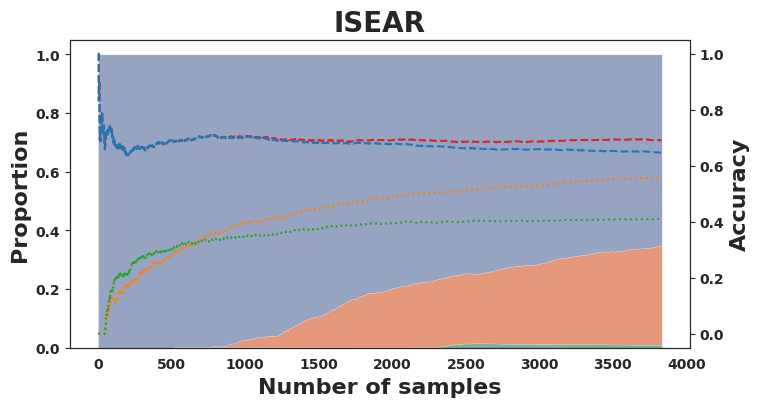

In [13]:
dataset_name = 'ISEAR'
log_dir = "./paper_logs/GPT/isear-GPT-small/"

colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()
log_name = 'LR_BERT-base_0.001760.log'
plt.figure(figsize=(6, 4.5))

cascade_size = len(log_name.split('_')) - 1
print(cascade_size)
model_prop = [[] for i in range(cascade_size)]
llm_prop = []
model_accu = [[] for i in range(cascade_size)]
model_de_facto_accu = [[] for i in range(cascade_size)]
llm_acc, overall_acc = [], []
with open(log_dir + log_name) as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        for k in range(cascade_size):
            model_prop[k].append(float(data[k + cascade_size + 2]))
        llm_prop.append(1 - sum(model_prop[i][-1] for i in range(cascade_size)))
        for k in range(cascade_size):
            model_de_facto_accu[k].append(float(data[k + cascade_size * 3 + 2]))
        for k in range(cascade_size):
            model_accu[k].append(float(data[k + cascade_size * 4 + 2]))
        llm_acc.append(float(data[k + cascade_size * 4 + 3]))
        overall_acc.append(float(data[k + cascade_size * 4 + 4]))

with open(log_dir + log_name) as file:
    last_line = file.readlines()[-2]

final_prop = []
data = re.split(',', last_line.strip())
for k in range(cascade_size):
    final_prop.append(float(data[k + cascade_size + 2]))
    print (data[k + cascade_size + 2])
llm_cost = 1 - sum(final_prop)
print('LLM cost: ', llm_cost)
num_lines = sum(1 for line in open(log_dir + log_name))
LLM_abosolute_cost = llm_cost * num_lines
print('LLM absolute cost: ', LLM_abosolute_cost)
# round up the LLM cost to the nearest integer
LLM_abosolute_cost = int(LLM_abosolute_cost + 0.5)
    
# plot the proportion on a stacked plot
fig, ax1 = plt.subplots()
ax1.stackplot(range(len(overall_acc)), model_prop, llm_prop, labels=log_name.split('_')[:-1] + ["LLM"], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_xlabel('Number of samples', fontsize=16, weight='bold')
ax1.set_ylabel('Proportion', fontsize=16, weight='bold')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', fontsize=16, weight='bold')

ax2.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])
ax2.plot(llm_acc, '--', label='LLM Accuracy', color=colors2[0])

model_accu = model_accu[::-1]
for idx, label in enumerate(cascade_name.split('_')[::-1]):
    ax2.plot(model_accu[idx], ':', label=label + ' Accuracy', color=colors2[idx+1])

log_name = log_name.split('.')[1]
fig.set_size_inches(8, 4)
plt.title(dataset_name, weight='bold', fontsize=20)
plt.savefig(dataset_name + '_' + str(LLM_abosolute_cost) + '_' + LLM_name + '_cascade.pdf', bbox_inches='tight')
plt.show()

## hatespeech

2
0.3029
0.6025
LLM cost:  0.09460000000000002
LLM absolute cost:  506.2992000000001


/tmp/ipykernel_2016135/2339171877.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax3.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])
/tmp/ipykernel_2016135/2339171877.py:79: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax4.plot(overall_recall, 'r--', label='Overall Recall', color=colors2[3])


Saved file as  HATESPEECH_507_GPT_cascade.pdf


<Figure size 600x450 with 0 Axes>

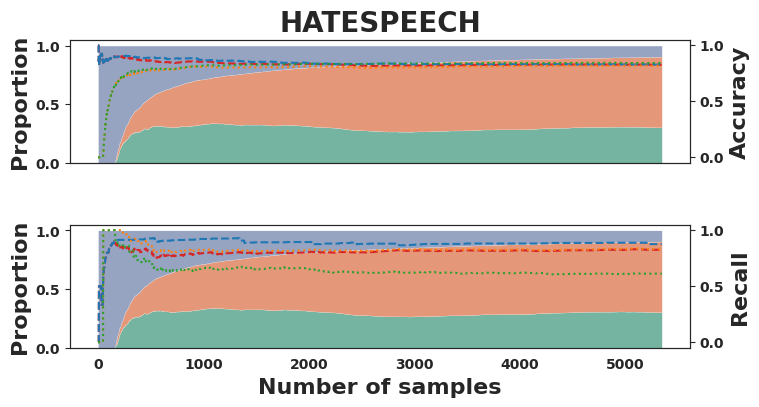

In [14]:
# example: LR: 0.3024;0.3987;0.3439 -> 0.3987
def get_recall(model_string):
    return float(model_string.split(';')[1])

dataset_name = 'HATESPEECH'
log_dir = "./paper_logs/GPT/hatespeech-GPT-small/"

colors = sns.color_palette("Set2", desat=.7)
colors2 = sns.color_palette()
log_name = 'LR_BERT-base_0.000110.log'
plt.figure(figsize=(6, 4.5))

cascade_size = len(log_name.split('_')) - 1
print(cascade_size)
model_prop = [[] for i in range(cascade_size)]
llm_prop = []
model_accu = [[] for i in range(cascade_size)]
model_de_facto_accu = [[] for i in range(cascade_size)]
model_recall = [[] for i in range(cascade_size)]
llm_acc, overall_acc = [], []
llm_recall, overall_recall = [], []
with open(log_dir + log_name) as file:
    for line in file.readlines():
        line = line.replace('na', '0')
        data = line.strip().split(',')
        for k in range(cascade_size):
            model_prop[k].append(float(data[k + cascade_size + 2]))
        llm_prop.append(1 - sum(model_prop[i][-1] for i in range(cascade_size)))
        for k in range(cascade_size):
            model_de_facto_accu[k].append(float(data[k + cascade_size * 3 + 2]))
        for k in range(cascade_size):
            model_accu[k].append(float(data[k + cascade_size * 4 + 2]))
        for k in range(cascade_size):
            model_recall[k].append(get_recall(data[k + cascade_size * 6 + 2]))
        llm_acc.append(float(data[k + cascade_size * 4 + 3]))
        overall_acc.append(float(data[k + cascade_size * 4 + 4]))
        llm_recall.append(get_recall(data[-2]))
        overall_recall.append(get_recall(data[-1]))

with open(log_dir + log_name) as file:
    last_line = file.readlines()[-2]

final_prop = []
data = re.split(',', last_line.strip())
for k in range(cascade_size):
    final_prop.append(float(data[k + cascade_size + 2]))
    print (data[k + cascade_size + 2])
llm_cost = 1 - sum(final_prop)
print('LLM cost: ', llm_cost)
num_lines = sum(1 for line in open(log_dir + log_name))
LLM_abosolute_cost = llm_cost * num_lines
print('LLM absolute cost: ', LLM_abosolute_cost)
# round up the LLM cost to the nearest integer
LLM_abosolute_cost = int(LLM_abosolute_cost + 1)
    
# plot the proportion on a stacked plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.5) 
ax1.stackplot(range(len(overall_acc)), model_prop, llm_prop, labels=log_name.split('_')[:-1] + ["LLM"], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax1.set_ylabel('Proportion', fontsize=16, weight='bold')
ax1.set_title(dataset_name, weight='bold', fontsize=20)
ax3 = ax1.twinx()
ax3.set_ylabel('Accuracy', fontsize=16, weight='bold')

ax3.plot(overall_acc, 'r--', label='Overall Accuracy', color=colors2[3])
ax3.plot(llm_acc, '--', label='LLM Accuracy', color=colors2[0])

model_accu = model_accu[::-1]
for idx, label in enumerate(cascade_name.split('_')[::-1]):
    ax3.plot(model_accu[idx], ':', label=label + ' Accuracy', color=colors2[idx+1])

ax2.stackplot(range(len(overall_acc)), model_prop, llm_prop, labels=log_name.split('_')[:-1] + ["LLM"], colors=colors, edgecolor='white', linewidth=0.1)
# set a color less transparent
ax2.set_xlabel('Number of samples', fontsize=16, weight='bold')
ax2.set_ylabel('Proportion', fontsize=16, weight='bold')
ax4 = ax2.twinx()
ax4.set_ylabel('Recall', fontsize=16, weight='bold')
ax4.plot(overall_recall, 'r--', label='Overall Recall', color=colors2[3])
ax4.plot(llm_recall, '--', label='LLM Recall', color=colors2[0])
model_recall = model_recall[::-1]
for idx, label in enumerate(cascade_name.split('_')[::-1]):
    ax4.plot(model_recall[idx], ':', label=label + ' Recall', color=colors2[idx+1])

log_name = log_name.split('.')[1]
fig.set_size_inches(8, 4)
plt.savefig(dataset_name + '_' + str(LLM_abosolute_cost) + '_' + LLM_name + '_cascade.pdf', bbox_inches='tight')
print("Saved file as ", dataset_name + '_' + str(LLM_abosolute_cost) + '_' + LLM_name + '_cascade.pdf')
plt.show()